# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

### I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 


In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
T=1 #On considère des calls 1 an
r = 0
S = 100
sigma = 0.2

In [3]:
data

,strikes,prices
0,95,10.93
1,96,9.55
2,97,8.28
3,98,7.40
4,99,6.86
5,100,6.58
6,101,6.52
7,102,6.49
8,103,6.47
9,104,6.46


In [4]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

In [5]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)

In [6]:
data

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [7]:
black_scholes_call_price(S, 95, T, r, 0.210948)

10.930002805693796

Interpolation des volatilités implicites

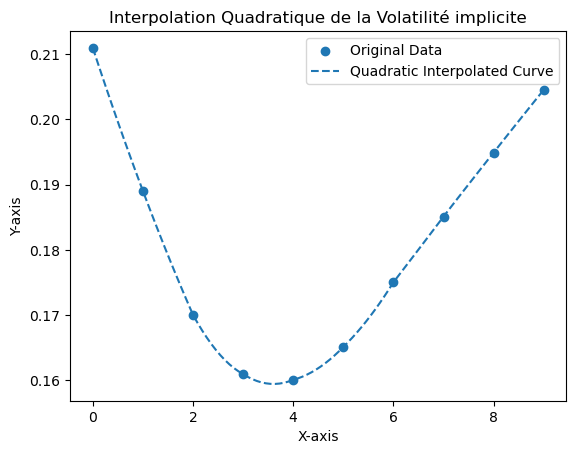

In [8]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, vol_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

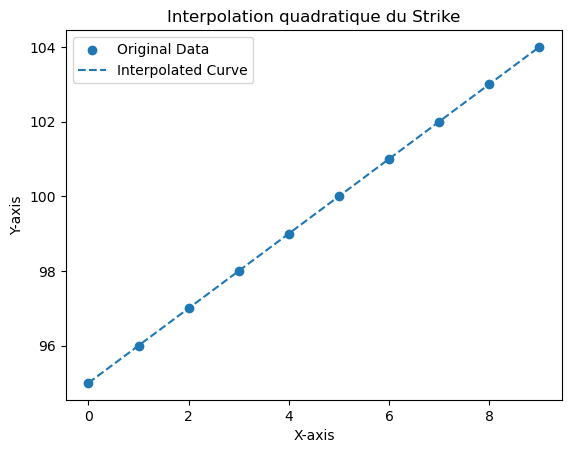

In [9]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

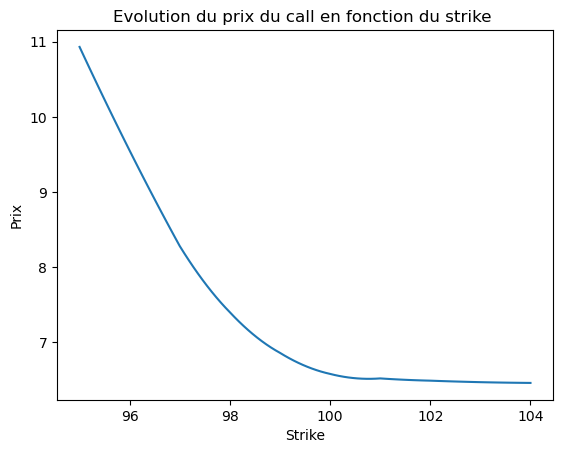

In [11]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [12]:
def neutral_risk_density(strikes , r , S , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S , K , T , r , implied_vols[i] )

     # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

In [15]:
data

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


Afin de comparer nos deux densités, nous devons ajuster notre gaussienne (voir comment déterminer les paramètres)

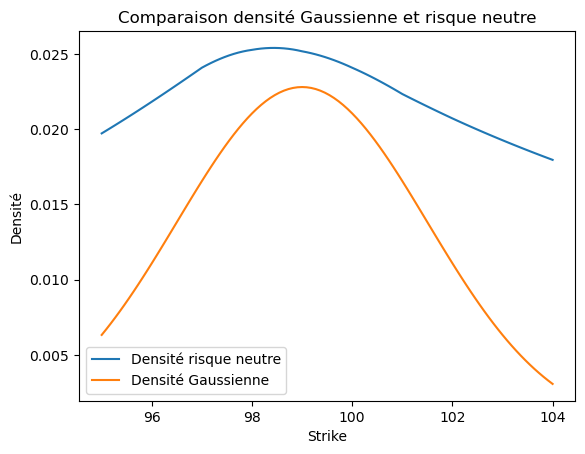

In [14]:
density_risque_neutre = neutral_risk_density (strike_interpolated , r , S , T , vol_interpolated )
density_gaussienne = norm.pdf (df["Strike"] , 99 , 2.5)/7

plt.plot(df["Strike"] , density_risque_neutre , label = "Densité risque neutre")
plt.plot(df["Strike"] , density_gaussienne , label = "Densité Gaussienne")
plt.xlabel( "Strike")
plt.ylabel( "Densité")
plt.legend()
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.show()

Nous centrons notre gaussienne de sorte à ce qu'elle soit comparable avec notre densité risque neutre (paramètre à déterminer)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

In [49]:
def monte_carlo_simulation(S, K, T, r, sigma, nb=1000):
    
    np.random.seed(123) 
    rand_values = np.random.normal(0, 1, nb)
    dt=T/252 #car on fait des pas daily
    
    st_price = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand_values)  
    option_price = [black_scholes_call_price(st, K, T, r, sigma) for st in st_price]
    
    option_price_mc = np.mean(option_price)   #moyenne des valeurs estimées
    
    return option_price_mc


for strike,vol,market_price in zip(data["strikes"],data["implied_vol"],data["prices"]):
    option_price_mc = monte_carlo_simulation(S, strike, T, r, vol, nb=1000)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}, Sigma = {vol:.2f} : {option_price_mc:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc-market_price):.2f}")


Prix par simulation de Monte Carlo pour K = 95, Sigma = 0.21 : 10.91
Market Price = 10.93, Difference = 0.02
Prix par simulation de Monte Carlo pour K = 96, Sigma = 0.19 : 9.54
Market Price = 9.55, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 97, Sigma = 0.17 : 8.27
Market Price = 8.28, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 98, Sigma = 0.16 : 7.39
Market Price = 7.40, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 99, Sigma = 0.16 : 6.85
Market Price = 6.86, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 100, Sigma = 0.17 : 6.57
Market Price = 6.58, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 101, Sigma = 0.18 : 6.51
Market Price = 6.52, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 102, Sigma = 0.19 : 6.48
Market Price = 6.49, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 103, Sigma = 0.19 : 6.46
Market Price = 6.47, Difference = 0.01
Prix par simulation de Monte Ca

On trouve donc un prix de modèle proche du prix de marché pour toutes les options. 